In [ ]:
!pip install networkx matplotlib pandas memory-profiler >/dev/null

In [ ]:
# Standard imports
import itertools
import math
import time
import json
from functools import lru_cache
from collections import defaultdict
import heapq

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

%matplotlib inline


In [ ]:
# -----------------------------
# Input modeling
# -----------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30
n = len(locations)

# small helper wrappers used across cells
def idx(name):
    return locations.index(name)

def travel_time(a, b):
    return distance_matrix[a][b]


In [ ]:
# -----------------------------
# Recurrence (TSP-style recursion with memoization)
# -----------------------------
from functools import lru_cache

@lru_cache(None)
def delivery_cost_recursive(pos, visited_mask):
    ALL = (1 << n) - 1
    if visited_mask == ALL:
        # return to warehouse
        return travel_time(pos, 0)
    best = float('inf')
    for nxt in range(n):
        if not (visited_mask & (1 << nxt)):
            cost = travel_time(pos, nxt) + delivery_cost_recursive(nxt, visited_mask | (1 << nxt))
            if cost < best:
                best = cost
    return best

start_mask = 1 << 0
min_tour_cost = delivery_cost_recursive(0, start_mask)
print("Recurrence (exact) minimal tour cost:", min_tour_cost)


Recurrence (exact) minimal tour cost: 18


In [ ]:
# -----------------------------
#  Greedy 0/1 knapsack by value/weight
# -----------------------------
items = []
for cname, attrs in parcels.items():
    items.append((cname, attrs['value'], attrs['weight'], attrs['time']))
items_sorted = sorted(items, key=lambda x: x[1]/x[2], reverse=True)

cap = vehicle_capacity
selected_greedy = []
cap_left = cap
for it in items_sorted:
    if it[2] <= cap_left:
        selected_greedy.append(it)
        cap_left -= it[2]

selected_names = [x[0] for x in selected_greedy]
total_value_selected = sum(x[1] for x in selected_greedy)
total_weight_selected = sum(x[2] for x in selected_greedy)
print("Greedy selected parcels:", selected_names, "value:", total_value_selected, "weight:", total_weight_selected)


Greedy selected parcels: ['C1', 'C2'] value: 110 weight: 30


In [ ]:
# -----------------------------
#  Time-window DP (bitmask) enumerating feasible end states
# -----------------------------
customer_indices = [idx(c) for c in parcels.keys()]
parcel_by_index = {idx(c): parcels[c] for c in parcels}

def time_window_dp(consider_indices):
    """
    Returns:
      dp: dict mapping (mask, end_idx) -> earliest arrival_time
      feasible_routes: list of feasible route summaries (mask,end,arrival,visited,value,weight)
    """
    m = len(consider_indices)
    index_to_pos = {consider_indices[i]: i for i in range(m)}
    dp = {}
    # initialize: from warehouse to each start customer
    for i in consider_indices:
        arrival = travel_time(0, i)
        e, l = parcel_by_index[i]['time']
        if arrival <= l:
            arrival_time = max(arrival, e)
            mask = 1 << index_to_pos[i]
            dp[(mask, i)] = arrival_time

    feasible_routes = []
    for mask in range(1, 1 << m):
        for end_pos in range(m):
            if not (mask & (1 << end_pos)):
                continue
            end = consider_indices[end_pos]
            key = (mask, end)
            if key not in dp:
                continue
            atime = dp[key]
            # build visited list for reporting
            visited_names = []
            for pos in range(m):
                if mask & (1 << pos):
                    cust_idx = consider_indices[pos]
                    visited_names.append(locations[cust_idx])
            total_v = sum(parcels[nm]['value'] for nm in visited_names)
            total_w = sum(parcels[nm]['weight'] for nm in visited_names)
            feasible_routes.append({
                'mask': mask, 'end': end, 'arrival': atime,
                'visited': visited_names, 'value': total_v, 'weight': total_w
            })

            # extend from this end to any next customer
            for nxt_pos in range(m):
                if mask & (1 << nxt_pos):
                    continue
                nxt = consider_indices[nxt_pos]
                arrive = atime + travel_time(end, nxt)
                e, l = parcel_by_index[nxt]['time']
                if arrive <= l:
                    new_arrive = max(arrive, e)
                    new_mask = mask | (1 << nxt_pos)
                    key2 = (new_mask, nxt)
                    if key2 not in dp or new_arrive < dp[key2]:
                        dp[key2] = new_arrive
    return dp, feasible_routes

# Run DP for all customers and for greedy-selected subset
dp_all, feasible_all = time_window_dp(customer_indices)
selected_indices = [idx(name) for name in selected_names]
dp_sel, feasible_sel = time_window_dp(selected_indices) if selected_indices else ({}, [])

def best_feasible(feasible_list):
    best = None
    for ent in feasible_list:
        if ent['weight'] <= vehicle_capacity:
            if best is None or ent['value'] > best['value'] or (ent['value']==best['value'] and ent['arrival'] < best['arrival']):
                best = ent
    return best

best_all = best_feasible(feasible_all)
best_sel = best_feasible(feasible_sel)

print("Best feasible (all customers) under capacity:", best_all)
print("Best feasible (greedy-selected) under capacity:", best_sel)


Best feasible (all customers) under capacity: {'mask': 2, 'end': 2, 'arrival': 10, 'visited': ['C2'], 'value': 60, 'weight': 20}
Best feasible (greedy-selected) under capacity: {'mask': 2, 'end': 2, 'arrival': 10, 'visited': ['C2'], 'value': 60, 'weight': 20}


In [ ]:
# -----------------------------
# Small brute-force: maximize delivered value subject to capacity AND time windows
# -----------------------------
def maximize_value_under_capacity_and_windows():
    cust_names = list(parcels.keys())
    best = {'subset': [], 'value': 0, 'weight': 0, 'order': None}
    for r in range(1, len(cust_names)+1):
        for subset in itertools.combinations(cust_names, r):
            total_w = sum(parcels[c]['weight'] for c in subset)
            if total_w > vehicle_capacity:
                continue
            feasible_order = None
            for perm in itertools.permutations(subset):
                t = 0
                cur = 0
                ok = True
                arrival_times = []
                for c in perm:
                    j = idx(c)
                    t += travel_time(cur, j)
                    e,l = parcels[c]['time']
                    if t > l:
                        ok = False
                        break
                    t = max(t, e)
                    arrival_times.append(t)
                    cur = j
                if ok:
                    feasible_order = (perm, arrival_times)
                    break
            if feasible_order:
                val = sum(parcels[c]['value'] for c in subset)
                if val > best['value']:
                    best = {'subset': list(subset), 'value': val, 'weight': total_w, 'order': feasible_order}
    return best

best_value_solution = maximize_value_under_capacity_and_windows()
print("Best value solution under capacity & windows (brute):", best_value_solution)


Best value solution under capacity & windows (brute): {'subset': ['C2'], 'value': 60, 'weight': 20, 'order': (('C2',), [10])}


In [ ]:
# -----------------------------
#  Dijkstra & Prim MST
# -----------------------------
def dijkstra(start):
    dist = [float('inf')] * n
    dist[start] = 0
    prev = [None] * n
    pq = [(0, start)]
    while pq:
        d,u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        for v in range(n):
            if u == v: continue
            nd = d + distance_matrix[u][v]
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))
    return dist, prev

dist_from_wh, prev_nodes = dijkstra(0)
print("Dijkstra distances from Warehouse:", dist_from_wh)

def prim_mst():
    in_mst = [False]*n
    key = [float('inf')]*n
    parent = [-1]*n
    key[0] = 0
    for _ in range(n):
        u = min((key[i], i) for i in range(n) if not in_mst[i])[1]
        in_mst[u] = True
        for v in range(n):
            if not in_mst[v] and distance_matrix[u][v] < key[v]:
                key[v] = distance_matrix[u][v]
                parent[v] = u
    edges = []
    total = 0
    for v in range(1, n):
        edges.append((parent[v], v, distance_matrix[parent[v]][v]))
        total += distance_matrix[parent[v]][v]
    return edges, total

mst_edges, mst_total = prim_mst()
print("Prim MST edges:", mst_edges, "total weight:", mst_total)


Dijkstra distances from Warehouse: [0, 4, 8, 6]
Prim MST edges: [(0, 1, 4), (1, 2, 5), (2, 3, 3)] total weight: 12


In [ ]:
# -----------------------------
# TSP brute-force and Held-Karp
# -----------------------------
def tsp_bruteforce(locs, dist):
    ln = len(locs)
    indices = list(range(1, ln))
    best_cost = float('inf')
    best_perm = None
    for perm in itertools.permutations(indices):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < best_cost:
            best_cost = cost
            best_perm = perm
    route = [locs[0]] + [locs[i] for i in best_perm] + [locs[0]]
    return route, best_cost

def tsp_held_karp(dist):
    nloc = len(dist)
    N = 1 << nloc
    dp = [[float('inf')] * nloc for _ in range(N)]
    dp[1][0] = 0
    for mask in range(N):
        for u in range(nloc):
            if not (mask & (1<<u)):
                continue
            if dp[mask][u] == float('inf'):
                continue
            for v in range(nloc):
                if mask & (1<<v):
                    continue
                new_mask = mask | (1<<v)
                dp[new_mask][v] = min(dp[new_mask][v], dp[mask][u] + dist[u][v])
    full = (1<<nloc) - 1
    best = float('inf')
    for u in range(1, nloc):
        best = min(best, dp[full][u] + dist[u][0])
    return best

tsp_route, tsp_cost = tsp_bruteforce(locations, distance_matrix)
tsp_hk_cost = tsp_held_karp(distance_matrix)
print("TSP brute-force route:", tsp_route, "cost:", tsp_cost)
print("Held-Karp TSP cost:", tsp_hk_cost)


TSP brute-force route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] cost: 18
Held-Karp TSP cost: 18


In [ ]:
# -----------------------------
# Profiling: brute-force TSP runtime for k=3..6 nodes
# -----------------------------
def profile_tsp(max_nodes=6):
    results = []
    base = distance_matrix
    for k in range(3, max_nodes+1):
        locs = ['Warehouse'] + [f'C{i}' for i in range(1, k)]
        m = [[0]*k for _ in range(k)]
        for i in range(k):
            for j in range(k):
                if i < len(base) and j < len(base):
                    m[i][j] = base[i][j]
                else:
                    m[i][j] = abs(i-j) + 1
        t0 = time.time()
        route,cost = tsp_bruteforce(locs, m)
        elapsed = time.time() - t0
        results.append({'nodes': k, 'time_s': elapsed, 'cost': cost, 'route': route})
    return results

tsp_profile = profile_tsp(6)
print("TSP profiling (n=3..6):")
for r in tsp_profile:
    print(r)


TSP profiling (n=3..6):
{'nodes': 3, 'time_s': 1.2159347534179688e-05, 'cost': 17, 'route': ['Warehouse', 'C1', 'C2', 'Warehouse']}
{'nodes': 4, 'time_s': 6.67572021484375e-06, 'cost': 18, 'route': ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']}
{'nodes': 5, 'time_s': 1.4066696166992188e-05, 'cost': 19, 'route': ['Warehouse', 'C1', 'C2', 'C3', 'C4', 'Warehouse']}
{'nodes': 6, 'time_s': 6.031990051269531e-05, 'cost': 22, 'route': ['Warehouse', 'C1', 'C2', 'C3', 'C4', 'C5', 'Warehouse']}


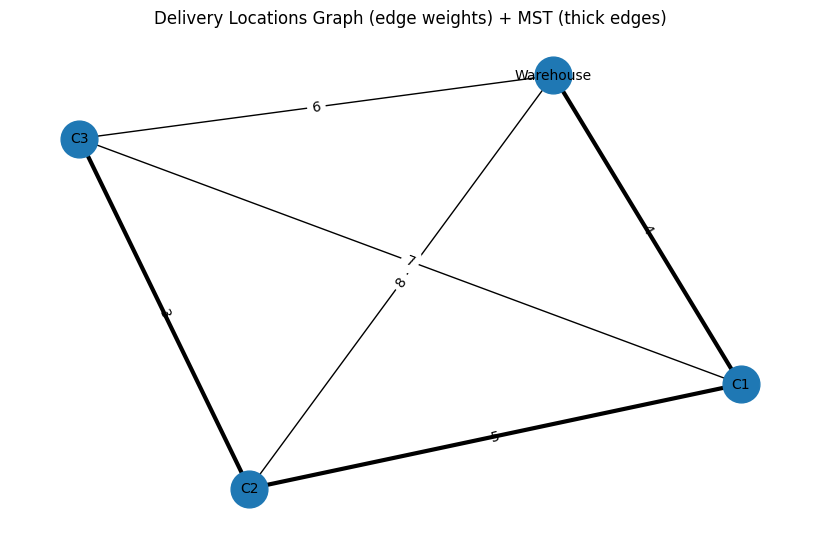

In [ ]:
# -----------------------------
# Visualization: delivery network + MST overlay
# -----------------------------
G = nx.Graph()
for i in range(n):
    G.add_node(locations[i])

for i in range(n):
    for j in range(i+1, n):
        G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8,5))
nx.draw(G, pos, with_labels=True, node_size=700, font_size=10)
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# overlay MST edges thicker
mst_edge_list = [(locations[u], locations[v]) for (u,v,w) in mst_edges]
nx.draw_networkx_edges(G, pos, edgelist=mst_edge_list, width=3, style='solid')

plt.title("Delivery Locations Graph (edge weights) + MST (thick edges)")
plt.grid(True)
plt.show()


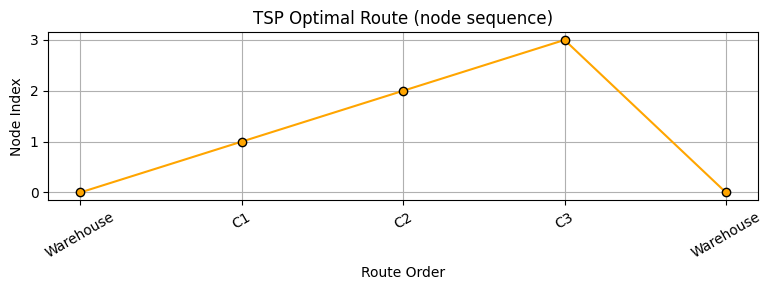

In [ ]:
# -----------------------------
# Plot: TSP route node-index progression
# -----------------------------
route_nodes = tsp_route
route_indices = [locations.index(r) for r in route_nodes]

plt.figure(figsize=(8,3))
plt.plot(
    range(len(route_indices)),
    route_indices,
    marker='o',
    color='orange',
    markerfacecolor='orange',
    markeredgecolor='black'
)

plt.xticks(range(len(route_indices)), route_nodes, rotation=30)
plt.xlabel("Route Order")
plt.ylabel("Node Index")
plt.title("TSP Optimal Route (node sequence)")
plt.grid(True)
plt.tight_layout()
plt.show()


,Customer,Value,Weight,Value/Weight
0,C1,50,10,5.000000
1,C2,60,20,3.000000
2,C3,40,15,2.666667


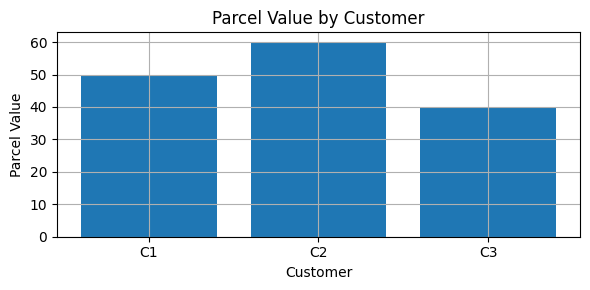

In [ ]:
# -----------------------------
# Parcels table and simple plots
# -----------------------------
df_items = pd.DataFrame([
    {'Customer':k, 'Value': parcels[k]['value'], 'Weight': parcels[k]['weight'],
     'Value/Weight': parcels[k]['value']/parcels[k]['weight']}
    for k in parcels
])

display(df_items)

# Bar: parcel value
plt.figure(figsize=(6,3))
plt.bar(df_items['Customer'], df_items['Value'])
plt.xlabel('Customer')
plt.ylabel('Parcel Value')
plt.title('Parcel Value by Customer')
plt.grid(True)
plt.tight_layout()
plt.show()



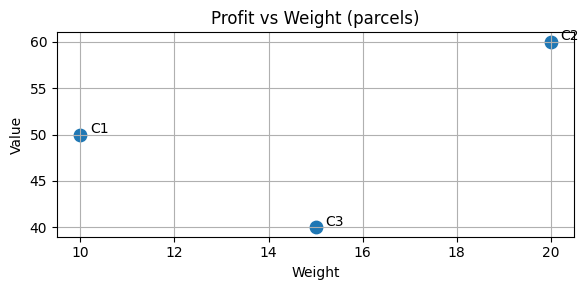

In [ ]:
# Scatter: weight vs value
plt.figure(figsize=(6,3))
plt.scatter(df_items['Weight'], df_items['Value'], s=80)
for i,row in df_items.iterrows():
    plt.text(row['Weight']+0.2, row['Value']+0.2, row['Customer'])
plt.xlabel('Weight')
plt.ylabel('Value')
plt.title('Profit vs Weight (parcels)')
plt.grid(True)
plt.tight_layout()
plt.show()


Plotting best_all delivery windows (if exists)...


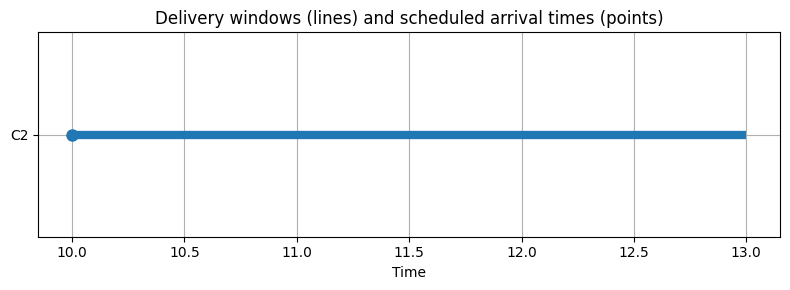

In [ ]:
# -----------------------------
# Delivery window plotter
# -----------------------------
def plot_delivery_windows_from_entry(entry):
    if not entry:
        print("No entry to plot.")
        return

    # use explicit order if available (best_value_solution uses 'order')
    if 'order' in entry and entry['order']:
        perm, arrivals = entry['order']
        order = perm
        arrivals = arrivals
    else:
        visited = entry.get('visited', [])
        found = False
        for perm in itertools.permutations(visited):
            t = 0
            cur = 0
            ok = True
            arrs = []
            for c in perm:
                j = idx(c)
                t += travel_time(cur, j)
                e,l = parcels[c]['time']
                if t > l:
                    ok = False
                    break
                t = max(t, e)
                arrs.append(t)
                cur = j
            if ok:
                order = perm
                arrivals = arrs
                found = True
                break
        if not found:
            print("Couldn't find explicit order to plot for this entry.")
            return

    plt.figure(figsize=(8,3))
    y = list(range(len(order)))
    for i,c in enumerate(order):
        e,l = parcels[c]['time']
        plt.hlines(y[i], e, l, linewidth=6)
        plt.plot(arrivals[i], y[i], 'o', markersize=8)
    plt.yticks(y, order)
    plt.xlabel('Time')
    plt.title('Delivery windows (lines) and scheduled arrival times (points)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Plotting best_all delivery windows (if exists)...")
plot_delivery_windows_from_entry(best_all)



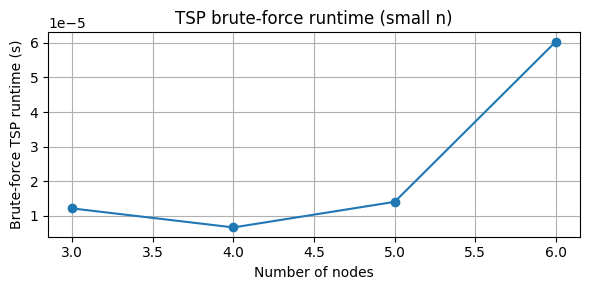

In [ ]:
# -----------------------------
# Plot: TSP brute-force runtime vs number of nodes
# -----------------------------
nodes = [r['nodes'] for r in tsp_profile]
times = [r['time_s'] for r in tsp_profile]

plt.figure(figsize=(6,3))
plt.plot(nodes, times, marker='o')
plt.xlabel('Number of nodes')
plt.ylabel('Brute-force TSP runtime (s)')
plt.title('TSP brute-force runtime (small n)')
plt.grid(True)
plt.tight_layout()
plt.show()
